# Animal Faces Classification using CNN (Pytorch)

**Overview**
<br>The objective of this project is to build a robust computer vision pipeline to classify high-quality animal facial images into three distinct categories: Cats, Dogs, and Wildlife. This notebook explores the efficacy of custom Convolutional Neural Networks (CNNs) in distinguishing between domestic and wild species using the AFHQ (Animal Faces High Quality) dataset.<br>

**Dataset & Preprocessing**
<br>The model is trained on the AFHQ Dataset from Kaggle, which provides diverse facial features for each class.

* Resolution: All images were resized to 128x128 pixels.
* Normalization: Normalized using ImageNet mean ($[0.485, 0.456, 0.406]$) and standard deviation ($[0.229, 0.224, 0.225]$) to leverage standardized color distributions.
* Split Strategy: A stratified 70/15/15 split was used to ensure that class proportions (Domestic vs. Wild) remained consistent across Training, Validation, and Testing sets, preventing demographic bias in the results.


**Model Architecture**
<br>I designed a custom PyTorch CNN focused on computational efficiency and spatial feature extraction:

* Feature Extractor: A 3-layer convolutional stack with increasing filter depth ($32 \to 64 \to 128$) to capture hierarchical details from simple edges to complex facial textures.
* Dimensionality Reduction: Max-pooling layers were used for spatial downsampling, followed by an Adaptive Average Pooling layer to fix the output size, making the model flexible to input variations.
* Classifier: A multi-layer perceptron (MLP) head with 128 hidden units and ReLU activations, outputting logits for the three target classes.

**Training Performance**
<br>The model was optimized using the Adam optimizer and Cross-Entropy Loss over 10 epochs.

* Final Training Accuracy: 97.23%
* Final Validation Accuracy: 96.65%
* Final Test Accuracy: 96.36%

In [81]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [82]:
image_path = []#Empty list to copy the image paths
labels = [] #Empty list to copy the labels
for i in os.listdir('/kaggle/input/datasets/andrewmvd/animal-faces/afhq/'):
    for label in os.listdir(f'/kaggle/input/datasets/andrewmvd/animal-faces/afhq/{i}'):
        for image in os.listdir(f'/kaggle/input/datasets/andrewmvd/animal-faces/afhq/{i}/{label}'):
            image_path.append(f'/kaggle/input/datasets/andrewmvd/animal-faces/afhq/{i}/{label}/{image}')
            labels.append(label)

In [83]:
# Create a DataFrame by pairing elements from image_path and labels,
df = pd.DataFrame({'Image_Path':image_path, 'Labels':labels})
df.head()

Image_Path Labels
0  /kaggle/input/datasets/andrewmvd/animal-faces/...    dog
1  /kaggle/input/datasets/andrewmvd/animal-faces/...    dog
2  /kaggle/input/datasets/andrewmvd/animal-faces/...    dog
3  /kaggle/input/datasets/andrewmvd/animal-faces/...    dog
4  /kaggle/input/datasets/andrewmvd/animal-faces/...    dog

**Sanity checks in the dataframe**

In [84]:
df['Labels'].unique()

array(['dog', 'wild', 'cat'], dtype=object)

In [85]:
df.duplicated().sum()

np.int64(0)

In [86]:
#Sanity check for duplicate indes
df.index.is_unique

True

In [87]:
df.shape

(16130, 2)

**Splitting the dataframe to train, val and test sets**

In [88]:
# #Assigning 70% of the data samples as train data
# train_df = df.sample(frac = 0.7, random_state=42)
# #Splitting data to test and val set
# test_df= df.drop(train_df.index)
# val_df = test_df.sample(frac = 0.5, random_state=42)
# test_df = test_df.drop(val_df.index)
# test_df.shape

In [89]:
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    random_state=42, 
    stratify=df['Labels']
)


val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['Labels']
)

# Verify the proportions
print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 11291
Val size: 2419
Test size: 2420


In [90]:
# Split df into Train (70%) and a temporary set (30%)
# The 'stratify=df['Labels']' ensures class proportions are preserved
train_df, temp_df= train_test_split(df, test_size=0.3, random_state=42, stratify=df['Labels'])
# Split the temporary set in half to get Validation (15%) and Test (15%)
# Again, we stratify by the labels in the temp_df
val_df, test_df= train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Labels'])
print(f'Train set size: {train_df.shape}| Val set size: {val_df.shape}| Test set size: {test_df.shape}')

Train set size: (11291, 2)| Val set size: (2419, 2)| Test set size: (2420, 2)


In [91]:
# Checking if the same percentages for each class across train , val and test dataframes
print(f'Train class counts: {train_df['Labels'].value_counts(normalize=True)}\n')
print(f'Val class counts: {val_df['Labels'].value_counts(normalize=True)}\n')
print(f'Test class counts: {test_df['Labels'].value_counts(normalize=True)}')

Train class counts: Labels
cat     0.350456
dog     0.324772
wild    0.324772
Name: proportion, dtype: float64

Val class counts: Labels
cat     0.350558
dog     0.324928
wild    0.324514
Name: proportion, dtype: float64

Test class counts: Labels
cat     0.350413
wild    0.324793
dog     0.324793
Name: proportion, dtype: float64


In [92]:
# Initialize the LabelEncoder object
le = LabelEncoder()

# 'Fit' the encoder only on the training data. 
# This identifies all unique classes (e.g., Cat=0, Dog=1).
le.fit(train_df['Labels'])

# Transform the text labels into integers for all three datasets.
# We use the mapping learned from the training set to ensure consistency.
train_df['Labels'] = le.transform(train_df['Labels'])
test_df['Labels'] = le.transform(test_df['Labels'])
val_df['Labels'] = le.transform(val_df['Labels'])

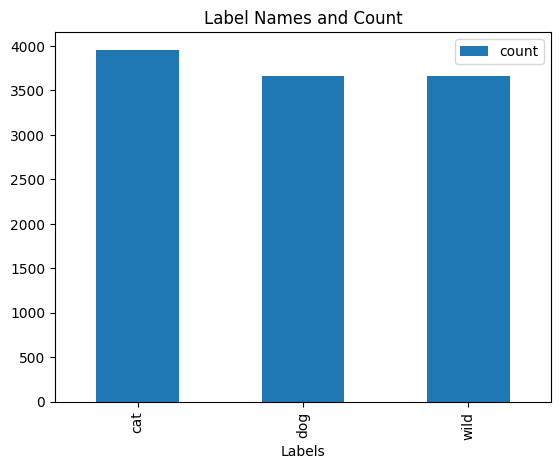

In [93]:
train_df['Labels'].value_counts().plot(kind='bar')
plt.legend()
plt.xticks(ticks = range(len(le.classes_)), labels=le.classes_)
plt.title('Label Names and Count')
plt.show()

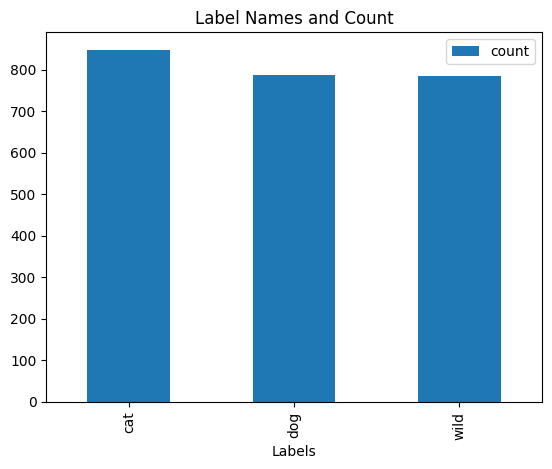

In [94]:
val_df['Labels'].value_counts().plot(kind='bar')
plt.legend()
plt.xticks(ticks = range(len(le.classes_)), labels=le.classes_)
plt.title('Label Names and Count')
plt.show()

In [95]:
label_mapping = {cls:idx for idx, cls in enumerate(le.classes_)}
label_mapping

{'cat': 0, 'dog': 1, 'wild': 2}

In [96]:
original_labels = le.inverse_transform([0,1,2])
original_labels

array(['cat', 'dog', 'wild'], dtype=object)

In [97]:
train_transform = transforms.Compose([
    # Resize slightly larger first to give space for cropping
    transforms.Resize((140, 140)),
    
    #Randomly crop a 128x128 piece and flip it 50% of the time
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Slight rotation to handle head tilts
    transforms.RandomRotation(degrees=15),
         
    # Normalize the image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Compose chains multiple image transformations together into a single pipeline.
test_transform = transforms.Compose([
    # Standardize image size. Neural networks require consistent input dimensions.
    # Here, we resize every image (regardless of original aspect ratio) to 128x128 pixels.
    transforms.Resize((128, 128)),
    
    # Convert the PIL Image or numpy.ndarray (0 to 255) to a FloatTensor (0.0 to 1.0).
    # This also reorders dimensions from (H, W, C) to (C, H, W) for PyTorch.
    transforms.ToTensor(),
    
    # Normalize the pixel values using the ImageNet dataset's mean and standard deviation.
    # This centers the data around zero, which helps the gradients stay stable.
    # Formula: input = (input - mean) / std
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [98]:
# Inheriting from Dataset allows us to use PyTorch's DataLoader later for batching.
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transforms=None):
        """
        Initializes the dataset object.
        :param dataframe: The Pandas DataFrame containing 'Image_Path' and 'Labels'.
        :param transforms: The PyTorch transformations to apply to each image.
        """
        self.dataframe = dataframe
        self.transforms = transforms

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        Required by the DataLoader to calculate steps per epoch.
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Loads and processes a single image-label pair based on the index.
        """
        # Retrieve the file path and integer label from the DataFrame row
        img_path = self.dataframe.iloc[idx]['Image_Path']
        label = self.dataframe.iloc[idx]['Labels']
        
        # Load the image and convert to RGB to ensure 3 color channels (removes transparency/alpha)
        image = Image.open(img_path).convert('RGB')
        
        # Apply Resize, ToTensor, and Normalization if provided
        if self.transforms:
            image = self.transforms(image)
            
        return image, label

In [99]:
# Create the training dataset object using the training DataFrame and preprocessing pipeline.
# This will be used by the model to learn patterns and update weights.
train_set = CustomImageDataset(train_df, transforms=train_transform)

# Create the validation dataset object. 
# This is used during training to evaluate performance and tune hyperparameters 
# without the model "seeing" the answers.
val_set = CustomImageDataset(val_df, transforms=test_transform)

# Create the test dataset object.
# This remains untouched until the very end to provide an unbiased 
# evaluation of the final model's accuracy.
test_set = CustomImageDataset(test_df, transforms=test_transform)

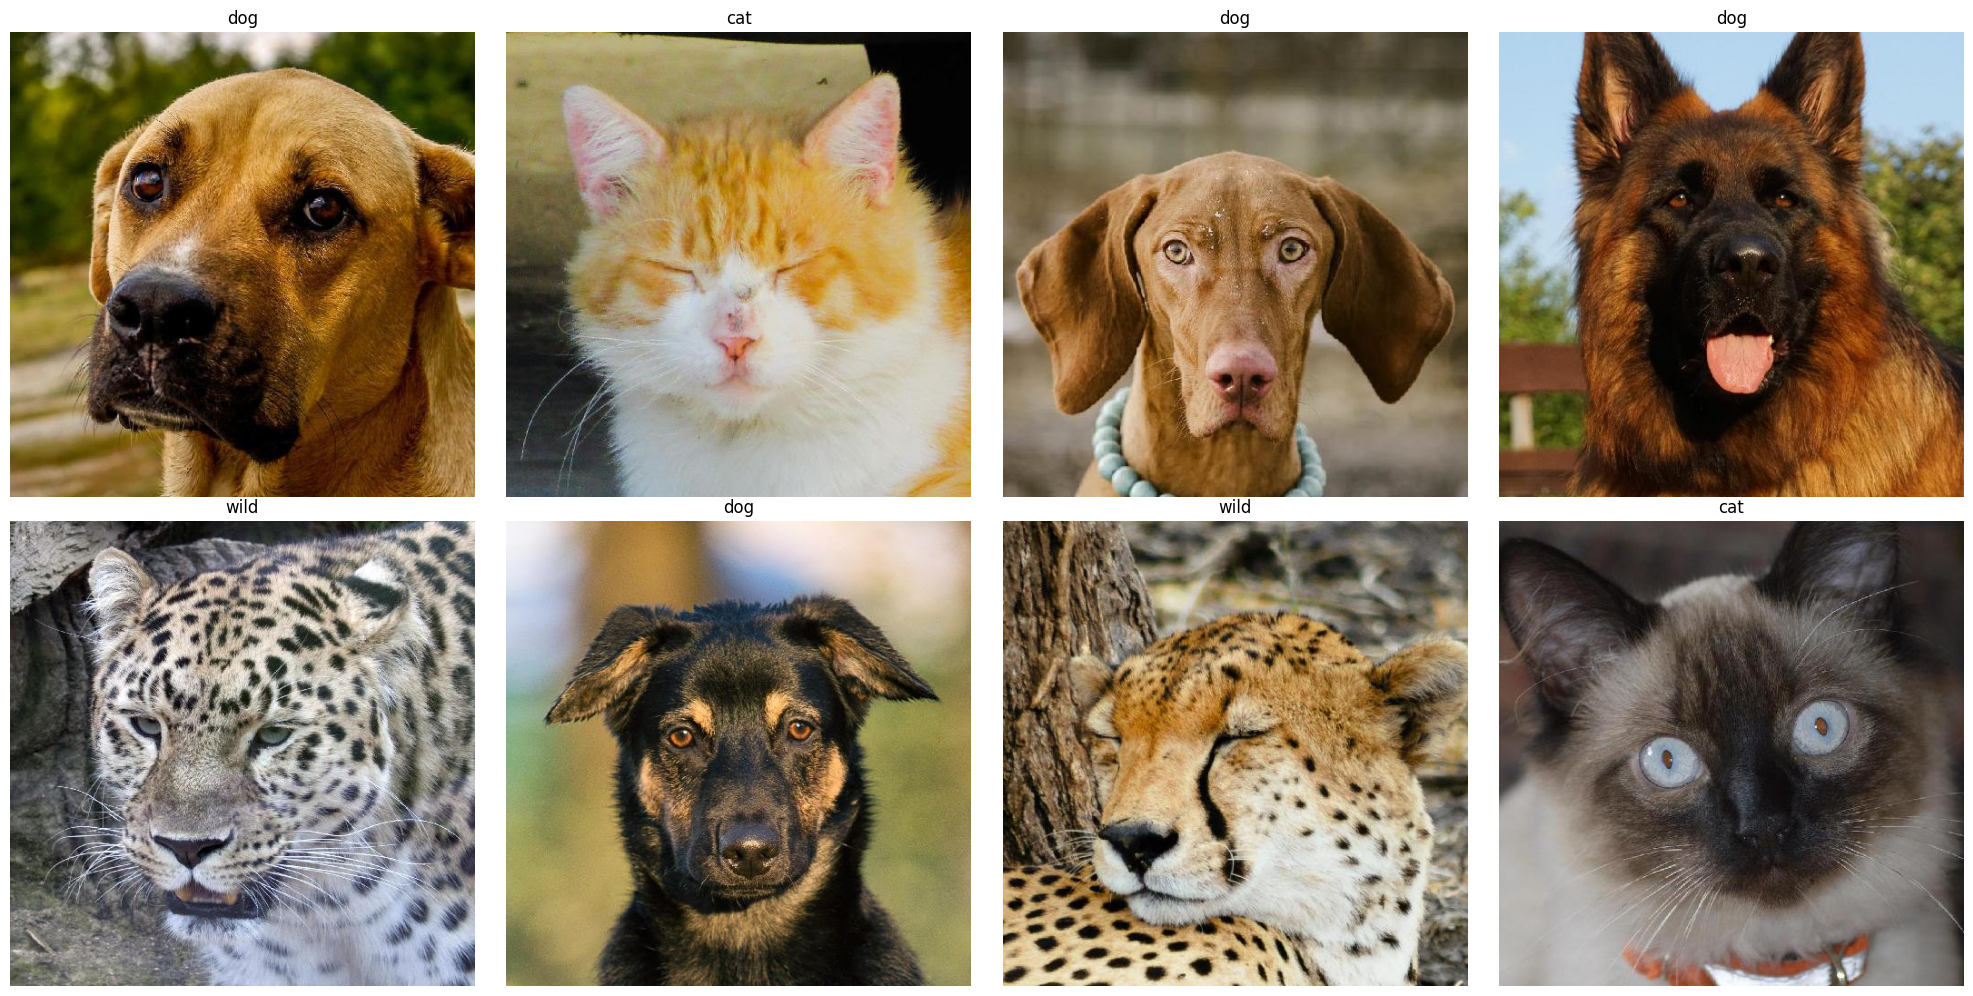

In [100]:
# Create a figure with a grid of 2 rows and 4 columns (8 subplots total).
# figsize=(20,10) ensures the images are large enough to see clearly.
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Flatten the 2x4 array of axes into a 1D array of 8 elements for easier looping.
axs_flat = axs.flatten()

# Loop through the subplots and the first 8 samples of the training data.
for i, ax in enumerate(axs_flat):
    # Retrieve the file path and integer label for the current index.
    img_path = train_df.iloc[i]['Image_Path']
    label = train_df.iloc[i]['Labels']
    
    # Convert the integer label back to its original text name (e.g., 0 -> "Cat").
    label_name = le.inverse_transform([label])[0]
    
    # Load the image file for display.
    img = Image.open(img_path).convert('RGB')
    
    # Display the image on the current subplot.
    ax.imshow(img)
    
    # Hide the x and y axis ticks/lines for a cleaner visual look.
    ax.axis('off')
    
    # Set the subplot title to the human-readable class name.
    ax.set_title(label_name)

# Adjust the padding between subplots to prevent titles from overlapping.
plt.tight_layout()

# Render the final plot to the screen.
plt.show()

**Data Pipeline Verification and Visual Sanity Check**
<br>Below visualization serves as a critical sanity check to ensure the data pipeline is functioning correctly before training begins. By pulling images directly from the train_set and reversing the normalization, we verify Data Integrity (ensuring file paths match their intended labels), Transformation Validation (checking that resizing to 128x128 hasn't overly distorted key features), and Label Encoding Accuracy (confirming that integer values map back to the correct human-readable categories via le.inverse_transform). This step is essential for catching mapping errors or preprocessing artifacts that could otherwise compromise the model's performance and reliability.

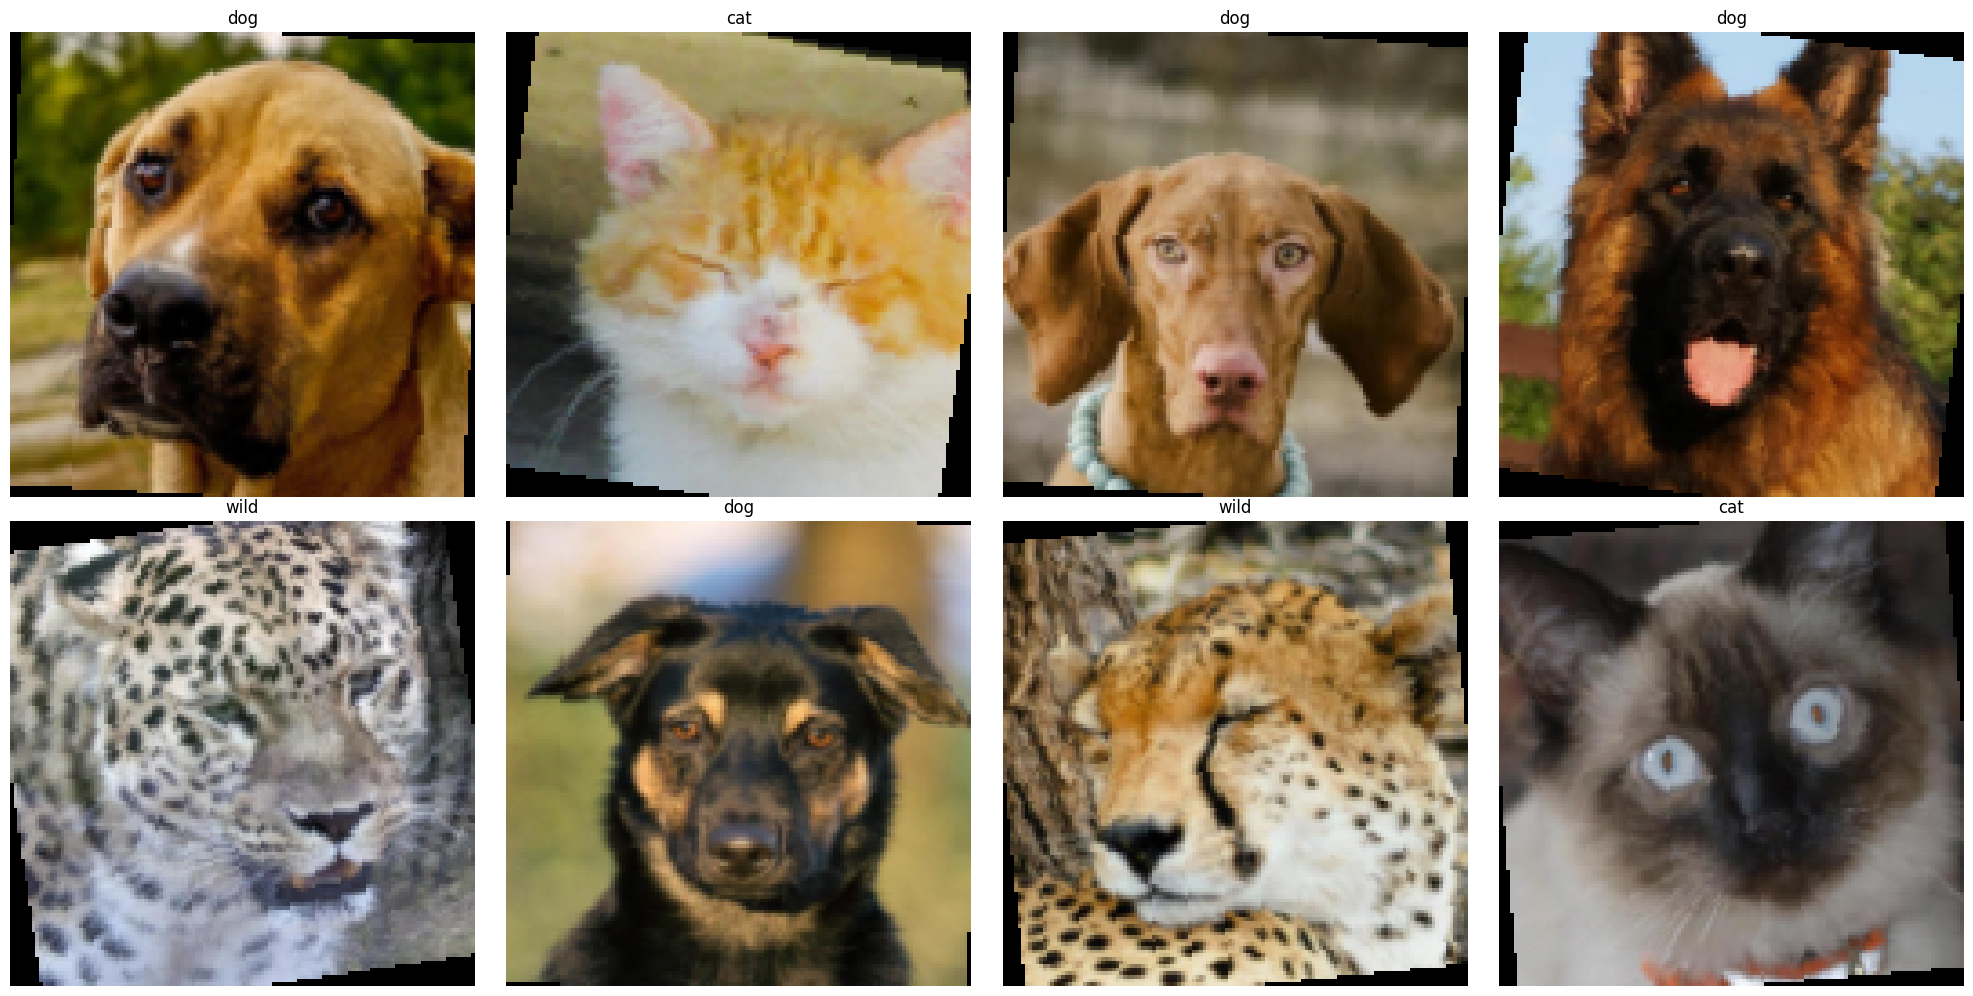

In [101]:
# Initialize a grid of 2 rows and 4 columns for a total of 8 preview images.
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Flatten the 2D axes array into 1D so we can iterate through it with a single index.
axs_flat = axs.flatten()

# Loop through the subplots and pull the first 8 items from the train_set.
for i, ax in enumerate(axs_flat):
    # Pull the transformed image tensor and integer label from our CustomImageDataset.
    img_tensor, label = train_set[i]
    
    # Decode the integer label back to its string name (e.g., 1  to 'Dog').
    label_name = le.inverse_transform([label])[0]
    
    # Reorder dimensions: PyTorch (Channel, Height, Width) to NumPy (Height, Width, Channel).
    # Matplotlib's imshow requires the color channel to be the last dimension.
    img_np = img_tensor.permute(1, 2, 0).numpy()
    
    # Define the ImageNet statistics used in the earlier normalization step.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Reverse the normalization: image = (z * std) + mean.
    # This restores the original color distribution for human viewing.
    img_np = (img_np * std) + mean
    
    # Ensure all pixel values are between 0 and 1 to prevent visual artifacts or errors.
    img_np = np.clip(img_np, 0, 1)
    
    # Plot the restored image.
    ax.imshow(img_np)
    
    # Remove coordinate axes for a cleaner gallery-style presentation.
    ax.axis('off')
    
    # Label each image with its corresponding class name.
    ax.set_title(label_name)

# Automatically adjust subplot parameters to give each image enough breathing room.
plt.tight_layout()

# Display the final plot.
plt.show()

In [102]:
from torch.utils.data import DataLoader

# Define the number of images to process in a single pass.
# Small batches (like 16) are great for memory efficiency and can help with generalization.
batch_size = 16

# The Training Loader: Essential to set shuffle=True so the model doesn't 
# learn the order of the data, which prevents overfitting.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# The Validation Loader: Used to evaluate the model during training.
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# The Test Loader: Used for the final evaluation. 
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [103]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes=3):
        # Initialize the parent nn.Module class
        super().__init__()

        # Feature Extractor: Learns spatial hierarchies (edges, textures, shapes)
        self.feature_extractor = nn.Sequential(
            # Layer 1: Input is 3 channels (RGB). Outputs 32 feature maps.
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Reduces spatial dimensions by half 

            # Layer 2: Deeper features.
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            # Layer 3: High-level features.
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Global Pooling: Forces the output to be exactly 1x1 per channel.
            nn.AdaptiveAvgPool2d((1,1))
        )

        # Classifier: Interprets the features to make a prediction
        self.classifier = nn.Sequential(
            nn.Flatten(), # Converts (Batch, 128, 1, 1) tensor to (Batch, 128)
            
            # Fully connected layer to learn relationships between features
            nn.Linear(128, 128), 
            nn.ReLU(),
            
            # Output layer: Returns 'logits' for each of your classes
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        """
        Defines the data flow through the network.
        x: Input batch of images [Batch, 3, 128, 128]
        """
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [104]:
# Check if a NVIDIA GPU is available and configured correctly with CUDA.
# If True, 'device' is set to 'cuda' for hardware acceleration.
# If False, it defaults to 'cpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Output the string ('cuda' or 'cpu') to verify which hardware PyTorch is targeting.
print(f'Device: {device}')

Device: cuda


In [105]:
# Instantiate the model and transfer all its parameters (weights/biases) 
# to the specified hardware (CPU or GPU).
model = Net(num_classes=3).to(device)

In [106]:
from torchsummary import summary
summary(model, input_size=(3,128,128))#provides the summary of the model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
          Flatten-11                  [-1, 128]               0
           Linear-12                  [-1, 128]          16,512
             ReLU-13                  [-1, 128]               0
           Linear-14                   

In [107]:
#Implementing the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [114]:
# Number of complete passes through the entire training dataset
epochs = 15

# Lists to track performance metrics over time for plotting later
total_train_loss, total_train_acc = [], []
total_val_loss, total_val_acc = [], [] 

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()  # Sets the model to training mode (enables Dropout/BatchNorm)
    running_train_loss = 0.0
    running_train_acc = 0
    
    for images, labels in train_loader:
        # Move a batch of data to the GPU (if available)
        images, labels = images.to(device), labels.to(device)
        
        # Forward Pass: Compute predictions
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Calculate Accuracy: Find the index of the highest logit
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).sum().item()
        
        # Accumulate metrics for the epoch
        running_train_loss += loss.item()
        running_train_acc += acc
        
        # Backward Pass: The optimization steps
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Compute new gradients (backpropagation)
        optimizer.step()      # Update weights based on gradients
        
    # --- VALIDATION PHASE ---
    model.eval()  # Sets the model to evaluation mode (disables Dropout/BatchNorm)
    
    running_val_loss = 0.0
    running_val_acc = 0
    
    # Disable gradient calculation to save memory and speed up inference
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            preds = torch.argmax(outputs, dim=1)
            acc = (preds == labels).sum().item()
            running_val_loss += loss.item()
            running_val_acc += acc
            
    # --- EPOCH SUMMARY ---
    # Calculate average loss per batch and total accuracy for the dataset
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_acc = running_train_acc / len(train_set)
    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_acc = running_val_acc / len(val_set)
    
    # Store results for visualization
    total_train_loss.append(epoch_train_loss) 
    total_train_acc.append(epoch_train_acc)
    total_val_loss.append(epoch_val_loss)
    total_val_acc.append(epoch_val_acc) 
    
    # Print real-time progress
    print(f'Epoch: {epoch+1} | train loss: {epoch_train_loss:.4f} | train acc: {epoch_train_acc:.4f} | val loss: {epoch_val_loss:.4f} | val acc: {epoch_val_acc:.4f}')

Epoch: 1 | train loss: 0.1755 | train acc: 0.9334 | val loss: 0.1952 | val acc: 0.9268
Epoch: 2 | train loss: 0.1579 | train acc: 0.9410 | val loss: 0.1618 | val acc: 0.9425
Epoch: 3 | train loss: 0.1421 | train acc: 0.9472 | val loss: 0.1485 | val acc: 0.9483
Epoch: 4 | train loss: 0.1391 | train acc: 0.9471 | val loss: 0.1561 | val acc: 0.9446
Epoch: 5 | train loss: 0.1260 | train acc: 0.9539 | val loss: 0.1295 | val acc: 0.9574
Epoch: 6 | train loss: 0.1278 | train acc: 0.9532 | val loss: 0.1904 | val acc: 0.9343
Epoch: 7 | train loss: 0.1216 | train acc: 0.9546 | val loss: 0.1411 | val acc: 0.9525
Epoch: 8 | train loss: 0.1080 | train acc: 0.9609 | val loss: 0.1191 | val acc: 0.9587
Epoch: 9 | train loss: 0.0944 | train acc: 0.9651 | val loss: 0.1175 | val acc: 0.9620
Epoch: 10 | train loss: 0.1006 | train acc: 0.9631 | val loss: 0.1072 | val acc: 0.9678
Epoch: 11 | train loss: 0.0869 | train acc: 0.9679 | val loss: 0.1304 | val acc: 0.9562
Epoch: 12 | train loss: 0.0896 | train ac

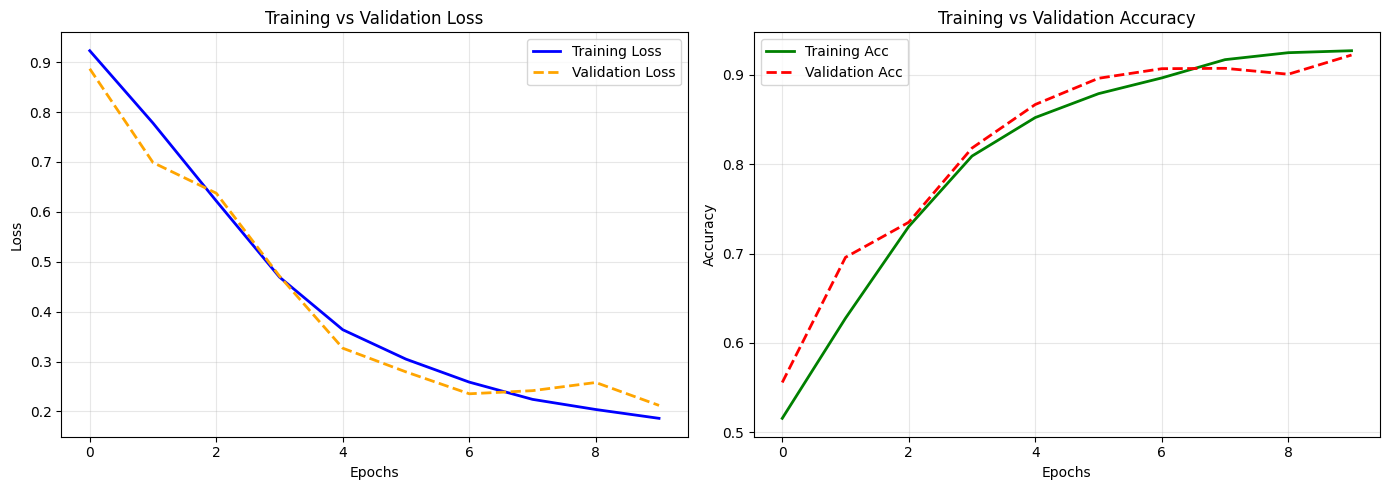

In [109]:
# Create a figure with two subplots
plt.figure(figsize=(14, 5))

# --- Plot 1: Loss ---
plt.subplot(1, 2, 1)
plt.plot(total_train_loss, label='Training Loss', color='blue', lw=2)
plt.plot(total_val_loss, label='Validation Loss', color='orange', lw=2, linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 2: Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(total_train_acc, label='Training Acc', color='green', lw=2)
plt.plot(total_val_acc, label='Validation Acc', color='red', lw=2, linestyle='--')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [117]:
# --- FINAL TEST EVALUATION ---
# Set the model to evaluation mode. This ensures consistent behavior 
# (e.g., if you later add Dropout, it will be disabled here).
model.eval()

running_test_loss = 0.0
running_test_acc = 0

# These lists will store every single prediction and true label for 
# detailed post-hoc analysis (like confusion matrices).
total_preds = []
total_labels = []

# 'no_grad' disables the gradient tracking engine, reducing memory 
# usage and speeding up the computation during inference.
with torch.no_grad():
    for images, labels in test_loader:
        # Move the test batch to the GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward Pass: Get the model's raw scores (logits)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Determine the predicted class index for each image in the batch
        preds = torch.argmax(outputs, dim=1)
        
        # Calculate how many predictions in this batch were correct
        acc = (preds == labels).sum().item()
        
        # Accumulate the loss and accuracy metrics
        running_test_loss += loss.item()
        running_test_acc += acc
        
        # Move data back to CPU and convert to NumPy for storage in our lists.
        # This is necessary because NumPy cannot live on the GPU.
        total_preds.extend(preds.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())

# Calculate the final average loss per batch and overall accuracy percentage
total_test_loss = running_test_loss / len(test_loader)
total_test_acc = running_test_acc / len(test_set)

print(f'Test loss: {total_test_loss:.4f} | Test acc: {total_test_acc:.4f}')

Test loss: 0.1160 | Test acc: 0.9636


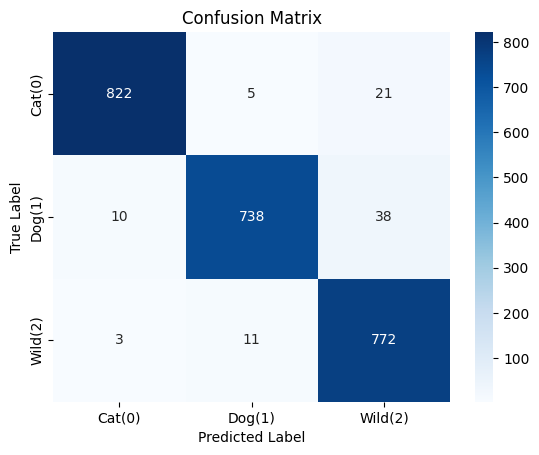

In [149]:
# Generate the confusion matrix values by comparing the true labels 
# against the model's predictions.
cm = confusion_matrix(total_labels, total_preds)

# Create a heatmap to visualize the matrix.
# xticklabels/yticklabels: Maps the encoded labels back to original class labels.
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat(0)', 'Dog(1)', 'Wild(2)'], 
            yticklabels=['Cat(0)', 'Dog(1)', 'Wild(2)'])

# Add descriptive labels for the axes.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the final plot.
plt.show()

**Predict function to Evaluate the model**

In [148]:
def predict_image(image_path, model, transform, le, device):
    # Load image and ensure it has 3 channels (RGB). 
    # This prevents errors if an image is accidentally uploaded as Grayscale or RGBA.
    img = Image.open(image_path).convert('RGB')
    
    # Apply the same Resize, ToTensor, and Normalize steps used in training.
    img_tensor = transform(img)
    
    # Add a 'Batch' dimension at index 0. 
    # Transforms (C, H, W) -> (1, C, H, W) because PyTorch models expect batches.
    img_tensor = img_tensor.unsqueeze(0)
    
    # Move the single-image batch to the GPU or CPU.
    img_tensor = img_tensor.to(device)
    
    # Set model to evaluation mode (disables layers like Dropout).
    model.eval()
    
    # Disable gradient tracking to save memory and compute power.
    with torch.no_grad():
        # Get raw model outputs (logits).
        output = model(img_tensor)
        
        # Pick the index with the highest score.
        pred_idx = torch.argmax(output, dim=1).item()
        
        # Convert the numeric index back to the string label (Cat, Dog, or Wild).
        class_name = le.inverse_transform([pred_idx])[0]
        
    return class_name 

In [147]:
os.listdir("/kaggle/input/datasets/nishadileep/test-images-for-dl/Images/")
# Path to your manually uploaded Kaggle test image.
test_image = "/kaggle/input/datasets/nishadileep/test-images-for-dl/Images/Image_2.jpg"

# Execute the prediction.
predict_image(test_image, model, transform, le, device)

'dog'